# Imports

In [8]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

colors = ['#346aa6', '#6699d3', '#2aa882', '#5dd3b0', '#ffb440', '#ff8240', '#f66b89', '#ec3b61']
c_pal = sns.set_palette(sns.color_palette(colors))
SEED = 42
stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())

# Data preprocessing

## Load

In [9]:
def show_plot(df: pd.DataFrame, field:str = 'emotion', rot: int = 45, xsize:int=20, order:list = None, p:list = ['#346aa6', '#6699d3', '#2aa882', '#5dd3b0', '#ffb440', '#ff8240', '#f66b89', '#ec3b61']):
    plt.figure(figsize = [xsize, 8])
    sns.countplot(x=df[field], palette=p, order = order)
    plt.xticks(rotation=rot, size=15)
    plt.yticks(size=15)
    plt.ylabel('Amount', size=20)
    plt.xlabel(field.title(), size=20)
    plt.show()

In [10]:
order = ['embarrassed', 'guilty', 'ashamed', 'terrified', 'anxious', 'apprehensive', 'angry', 'jealous', 'furious', 'sad', 'lonely', 'nostalgic', 'sentimental', 'trusting', 'anticipating', 'confident', 'surprised', 'joyful', 'devastated', 'proud', 'content', 'faithful', 'caring', 'hopeful']
p = ['#346aa6'] * 3 + ['#6699d3'] * 3 + ['#2aa882'] * 3 + ['#5dd3b0'] * 4 + ['#ffb440'] * 3 + ['#ff8240'] * 2 + ['#f66b89'] * 3 + ['#ec3b61'] * 3

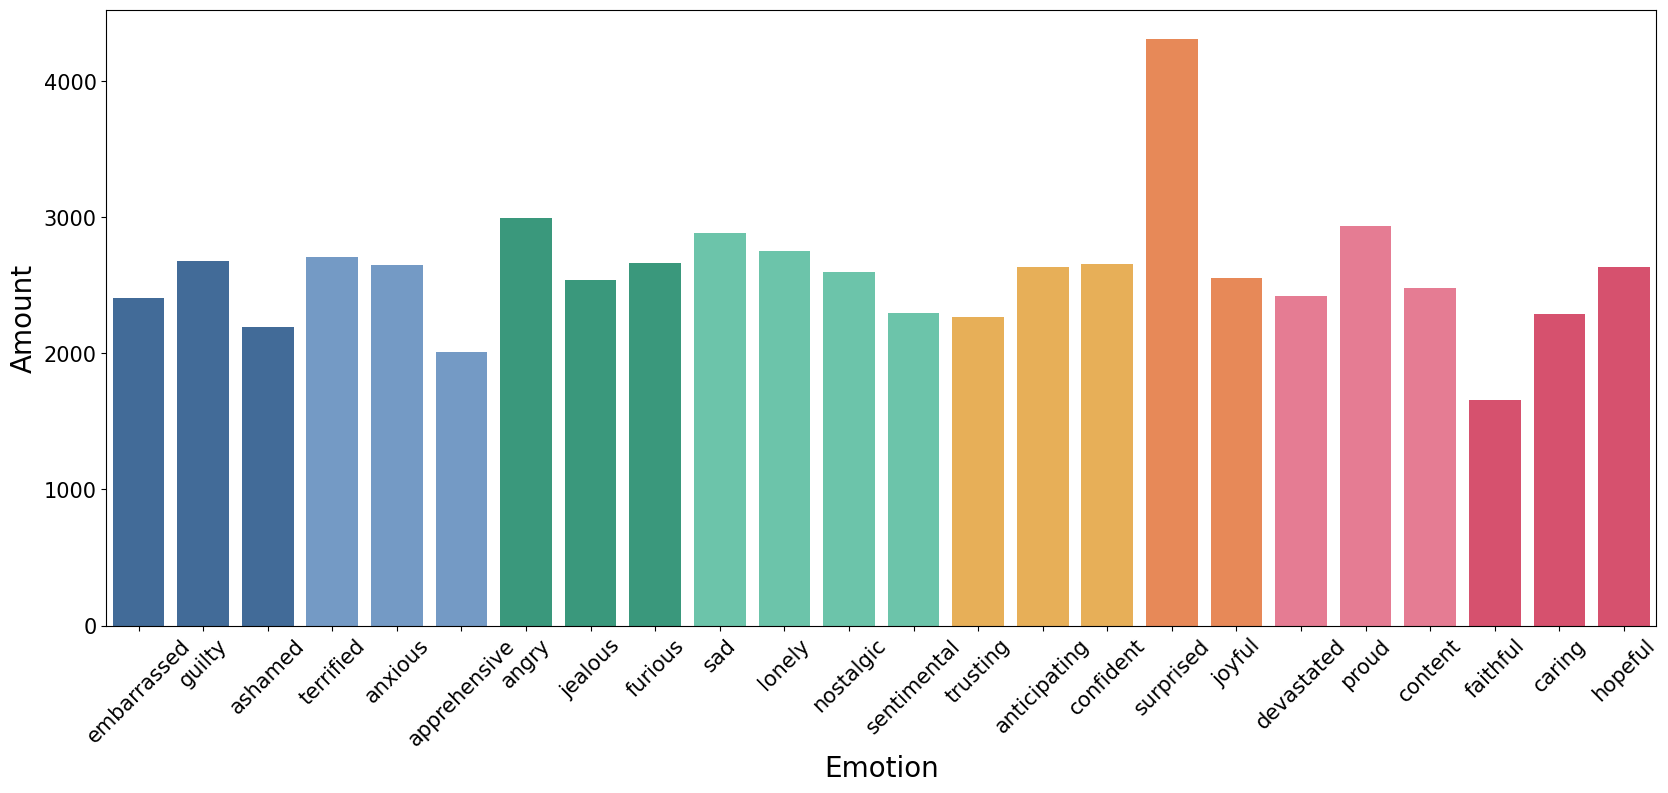

In [11]:
df = pd.read_csv('data/training_dataset.csv', sep=';')
show_plot(df, p=p, order=order)

## Filtering

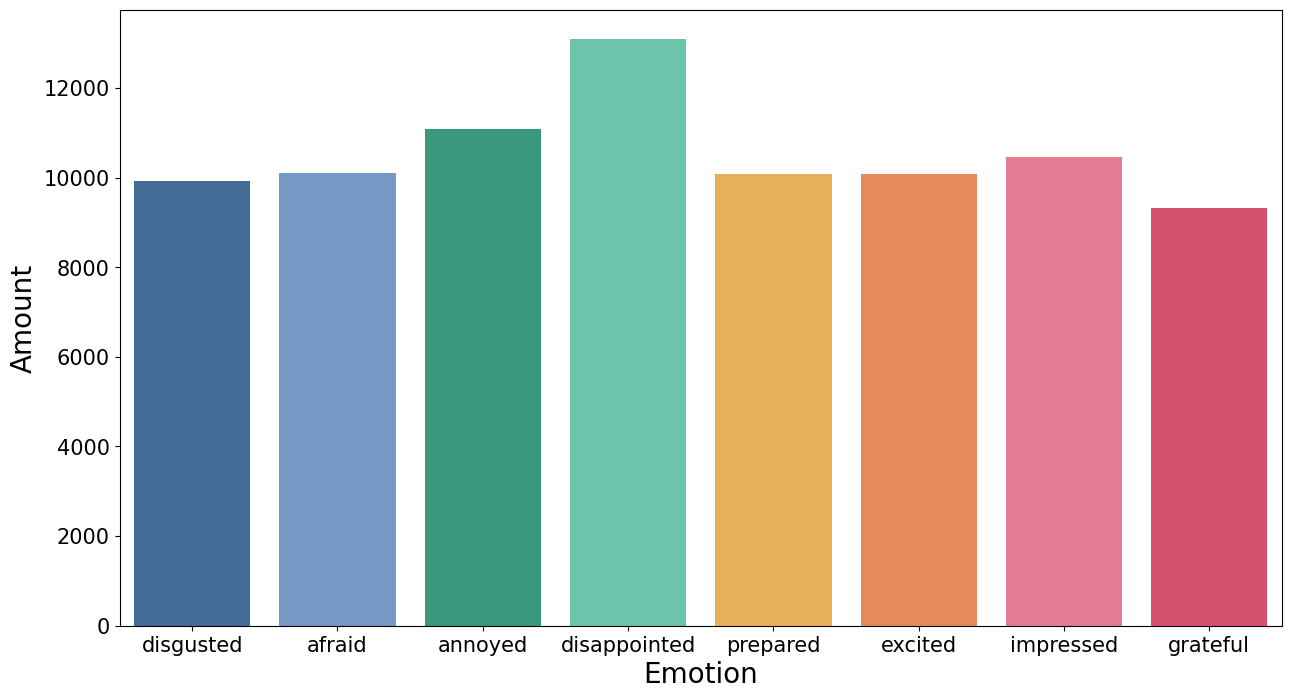

In [12]:
df.loc[df['emotion'] == 'embarrassed', 'emotion'] = "disgusted"
df.loc[df['emotion'] == 'guilty', 'emotion'] = "disgusted"
df.loc[df['emotion'] == 'ashamed', 'emotion'] = "disgusted"

df.loc[df['emotion'] == 'terrified', 'emotion'] = 'afraid'
df.loc[df['emotion'] == 'anxious', 'emotion'] = 'afraid'
df.loc[df['emotion'] == 'apprehensive', 'emotion'] = 'afraid'

df.loc[df['emotion'] == 'angry', 'emotion'] = "annoyed"
df.loc[df['emotion'] == 'jealous', 'emotion'] = "annoyed"
df.loc[df['emotion'] == 'furious', 'emotion'] = "annoyed"

df.loc[df['emotion'] == 'sad', 'emotion'] = "disappointed"
df.loc[df['emotion'] == 'lonely', 'emotion'] = "disappointed"
df.loc[df['emotion'] == 'nostalgic', 'emotion'] = "disappointed"
df.loc[df['emotion'] == 'sentimental', 'emotion'] = "disappointed"

df.loc[df['emotion'] == 'trusting', 'emotion'] = "prepared"
df.loc[df['emotion'] == 'anticipating', 'emotion'] = "prepared"
df.loc[df['emotion'] == 'confident', 'emotion'] = "prepared"

df.loc[df['emotion'] == 'surprised', 'emotion'] = 'excited'
df.loc[df['emotion'] == 'joyful', 'emotion'] = 'excited'

df.loc[df['emotion'] == 'devastated', 'emotion'] = "impressed"
df.loc[df['emotion'] == 'proud', 'emotion'] = "impressed"
df.loc[df['emotion'] == 'content', 'emotion'] = "impressed"

df.loc[df['emotion'] == 'faithful', 'emotion'] = "grateful"
df.loc[df['emotion'] == 'caring', 'emotion'] = "grateful"
df.loc[df['emotion'] == 'hopeful', 'emotion'] = "grateful"

order = ['disgusted', 'afraid', 'annoyed', 'disappointed', 'prepared', 'excited', 'impressed', 'grateful']
show_plot(df, rot = 0, xsize=15, order=order)

## Downsampling

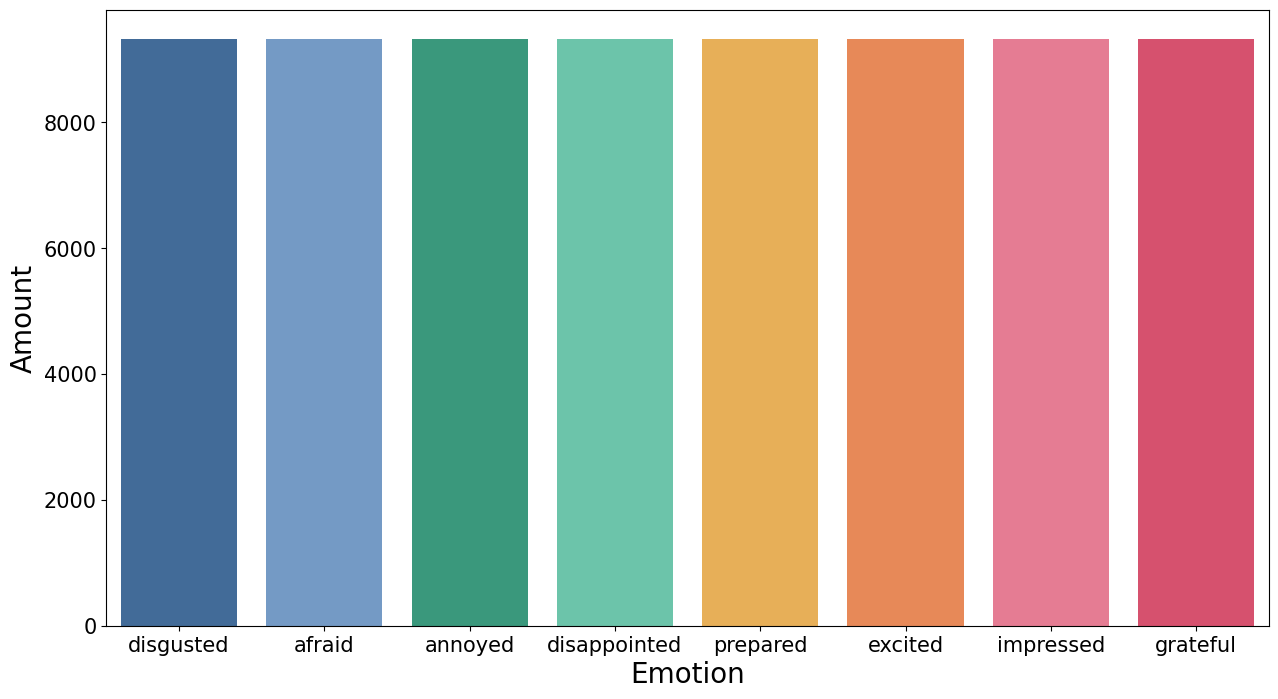

In [13]:

selected_categories = list(df['emotion'].unique())
selected_df = df[df['emotion'].isin(selected_categories)]
df_downsample = df[df['emotion'] == selected_df['emotion'].value_counts().sort_values().index[0]].sample(n=selected_df['emotion'].value_counts().sort_values()[0], random_state=SEED)
for i in range(len(selected_df['emotion'].unique()) - 1):
    df_downsample = pd.concat(
        [
            df_downsample, 
            df[df['emotion'] == selected_df['emotion'].value_counts().sort_values().index[i + 1]].sample(n=selected_df['emotion'].value_counts().sort_values()[0], random_state=SEED)
        ]
    )

show_plot(df_downsample, rot = 0, xsize=15, order=order)

## Context classification

### Prepare data

In [6]:
init_df: pd.DataFrame = pd.read_csv('data/categories_dataset.csv', sep=';')

SC = list(init_df['category'].unique())
selected_df_1 = init_df[init_df['category'].isin(SC)]
df_downsample_cat = init_df[init_df['category'] == selected_df_1['category'].value_counts().sort_values().index[0]].sample(n=selected_df_1['category'].value_counts().sort_values()[0], random_state=SEED)
for i in range(len(selected_df_1['category'].unique()) - 1):
    df_downsample_cat = pd.concat(
        [
            df_downsample_cat, 
            init_df[init_df['category'] == selected_df_1['category'].value_counts().sort_values().index[i + 1]].sample(n=selected_df_1['category'].value_counts().sort_values()[0], random_state=SEED)
        ]
    )

In [7]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed)
        if word not in stopword])
    text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    return text

df_downsample['ft_q'] = df_downsample['question'].map(lambda x: clean_text(x))
df_downsample_cat["text"] = df_downsample_cat["headline"]
df_downsample_cat['text'] = df_downsample_cat['text'].map(lambda x: clean_text(x))
X, y = df_downsample_cat['text'], df_downsample_cat["category"]

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(df_downsample_cat['text'], df_downsample_cat['category'], test_size=0.2, stratify=df_downsample_cat['category'])

le = sk.preprocessing.LabelEncoder()
le.fit(SC)
y_train_label = le.transform(y_train)
y_test_label = le.transform(y_test)

tf_idf_vectorizer = sk.feature_extraction.text.TfidfVectorizer()
X_train_t = tf_idf_vectorizer.fit_transform(X_train)
X_test_t = tf_idf_vectorizer.transform(X_test)

In [8]:
maxlen = 200
oov_token = "<oov_token>"
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token = oov_token)
tokenizer.fit_on_texts(df_downsample_cat.text.to_list()+df_downsample.ft_q.to_list()) 

word_index = {}
word_index = tokenizer.word_index
vocabulary = len(word_index) +1
                                            
X_tokenizer = tokenizer.texts_to_sequences(df_downsample_cat.text.to_list())
X_predict = tokenizer.texts_to_sequences(df_downsample.ft_q.to_list())
X_padded = tf.keras.preprocessing.sequence.pad_sequences(X_tokenizer, maxlen=maxlen, truncating='post',padding='pre')
X_predict_padded = tf.keras.preprocessing.sequence.pad_sequences(X_predict, maxlen=maxlen, truncating='post',padding='pre')

Y = pd.get_dummies(df_downsample_cat['category'].values)

X_train_padded, X_test_padded, Y_train_dummy, Y_test_dummy = sk.model_selection.train_test_split(X_padded, Y, test_size=0.2, random_state=SEED)

### Import GLOVE

In [9]:
glove_dictionary = {}
with open('data/glove.6B.200d.txt',encoding="utf8") as file:
    for each_line in file:
        words_in_line, coeff_cients = each_line.split(maxsplit=1)
        coeff_cients = np.array(coeff_cients.split(),dtype = float)
        glove_dictionary[words_in_line] = coeff_cients

embedding_matrix = np.zeros((vocabulary, maxlen))
for word, i in word_index.items():
    embedding_vector = glove_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Train Model

In [10]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(vocabulary, 200, weights=[embedding_matrix], input_length=maxlen))
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(32, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(len(SC), activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['AUC', 'Recall', 'Precision', 'accuracy'])

# train and validate the model on the padded sequences of text which we have created initially       
model.fit(
    X_train_padded, 
    Y_train_dummy, 
    epochs=110, 
    verbose=1,
    batch_size=64,
    validation_split=0.1,
    validation_data=(
        X_test_padded, 
        Y_test_dummy
        )
    )

Epoch 1/110
1114/1114 [==============================] - 35s 29ms/step - loss: 2.1753 - auc: 0.5640 - recall: 0.6199 - precision: 0.1271 - accuracy: 0.1472 - val_loss: 2.1163 - val_auc: 0.6804 - val_recall: 0.7724 - val_precision: 0.1520 - val_accuracy: 0.2618
Epoch 2/110
1114/1114 [==============================] - 32s 29ms/step - loss: 2.0604 - auc: 0.6851 - recall: 0.7683 - precision: 0.1546 - accuracy: 0.2703 - val_loss: 1.9631 - val_auc: 0.7615 - val_recall: 0.8471 - val_precision: 0.1667 - val_accuracy: 0.4075
Epoch 3/110
1114/1114 [==============================] - 32s 29ms/step - loss: 1.8971 - auc: 0.7474 - recall: 0.8329 - precision: 0.1681 - accuracy: 0.3671 - val_loss: 1.7555 - val_auc: 0.8074 - val_recall: 0.8950 - val_precision: 0.1748 - val_accuracy: 0.4690
Epoch 4/110
1114/1114 [==============================] - 33s 29ms/step - loss: 1.7246 - auc: 0.7847 - recall: 0.8676 - precision: 0.1758 - accuracy: 0.4246 - val_loss: 1.5688 - val_auc: 0.8383 - val_recall: 0.9183 - v

In [17]:
df_downsample['category'] = [SC[int(tf.argmax(i).numpy())] for i in model.predict(X_predict_padded, verbose=1)]
df_downsample = df_downsample[['question', 'answer', 'emotion', 'category']]

2332/2332 [==============================] - 21s 9ms/step


In [18]:
df_downsample.head(7)
df_downsample.to_csv('data/dataset.csv', index=None, sep=';')

,question,answer,emotion,category
78172,I put a bid in for a new house! I don't know y...,Last week I put in a bid to purchase my first ...,grateful,SPORTS
21712,I had a bad day at work and my girlfriend made...,Well i am so glad my girlfriend was there when...,grateful,BUSINESS
63520,I'm going to cooking school to become a chef.,That's pretty cool. Maybe you could toss me a ...,grateful,BUSINESS
33812,I'm faithful I'm going down the right career p...,man thats awesome_comma_ i have a friend who i...,grateful,MINORITIES
71069,One time while I was working an employee came ...,It's terrible when people can't take no for an...,grateful,ENTERTAINMENT
7060,I pray I pass the bar exam next week.,No I take it next week.,grateful,POLITICS
50337,A coworker helped me move to another city. He ...,No_comma_ I sold the heavy appliances before m...,grateful,ENTERTAINMENT


# Transformer

In [2]:
from chatbot.transformer import Transformer
import pandas as pd
data = pd.read_csv('data/dataset.csv', sep=';')
model = Transformer(num_epoch=100)

## Additional classificators training

In [3]:
model.fit_data(data=data)
model.train_classificators(num_ep=5)
model.save_to_folder('trained_models/transformer/')

<class 'tensorflow.python.data.ops.dataset_ops.DatasetV2'>: Dictionary generation Corpus(lang='en', max_length=30, batch_size=32, buffer_size=20000, _start_token=0, _end_token=0, _vocab_size=0, fre=0.0, av_sent_len=0.0). 
	Please be patient. Depending on the size of the dataset and 
	the number of unique words, this can take a while (up to 5 minutes).
Epoch 1/5
1901/1901 [==============================] - 28s 12ms/step - loss: 1.3924 - auc: 0.8307 - recall: 0.7895 - precision: 0.2690 - accuracy: 0.4450
Epoch 2/5
1901/1901 [==============================] - 23s 12ms/step - loss: 0.6476 - auc: 0.9581 - recall: 0.9379 - precision: 0.4242 - accuracy: 0.7926
Epoch 3/5
1901/1901 [==============================] - 24s 13ms/step - loss: 0.3112 - auc: 0.9860 - recall: 0.9722 - precision: 0.5130 - accuracy: 0.9117
Epoch 4/5
1901/1901 [==============================] - 22s 12ms/step - loss: 0.1880 - auc: 0.9932 - recall: 0.9848 - precision: 0.5758 - accuracy: 0.9469
Epoch 5/5
1901/1901 [=========

INFO:tensorflow:Assets written to: trained_models/emotion_detector\assets


INFO:tensorflow:Assets written to: trained_models/emotion_detector\assets


Epoch 1/5
1901/1901 [==============================] - 25s 12ms/step - loss: 1.3618 - auc: 0.8418 - recall: 0.8484 - precision: 0.2222 - accuracy: 0.5318
Epoch 2/5
1901/1901 [==============================] - 23s 12ms/step - loss: 0.5016 - auc: 0.9659 - recall: 0.9626 - precision: 0.3078 - accuracy: 0.8569
Epoch 3/5
1901/1901 [==============================] - 24s 13ms/step - loss: 0.2137 - auc: 0.9887 - recall: 0.9871 - precision: 0.3512 - accuracy: 0.9431
Epoch 4/5
1901/1901 [==============================] - 24s 13ms/step - loss: 0.1205 - auc: 0.9951 - recall: 0.9944 - precision: 0.3793 - accuracy: 0.9686
Epoch 5/5
1901/1901 [==============================] - 25s 13ms/step - loss: 0.0717 - auc: 0.9973 - recall: 0.9970 - precision: 0.4118 - accuracy: 0.9816


INFO:tensorflow:Assets written to: trained_models/classificator\assets


INFO:tensorflow:Assets written to: trained_models/classificator\assets


## Main model training

In [14]:
history = model.compile_model()

<class 'tensorflow.python.data.ops.dataset_ops.DatasetV2'>: Dictionary generation Corpus(lang='en', max_length=40, batch_size=32, buffer_size=20000, _start_token=0, _end_token=0, _vocab_size=0, fre=0.0, av_sent_len=0.0).
        Please be patient. Depending on the size of the dataset and
        the number of unique words, this can take a while (up to 5 minutes).
Data loaded with hyperparams: Corpus(lang='en', max_length=30, batch_size=32, buffer_size=20000, _start_token=[69175], _end_token=[69176], _vocab_size=69177, fre=87.513, av_sent_len=17.601).
<keras.engine.functional.Functional object at 0x7f637880ba30> compiled successfully.

Epoch 1/100
1901/1901 - 309s - loss: 2.14 - _count_accuracy: 0.0696 - _count_f1: 0.0696 - _count_mrr: 0.1012 - 309s/epoch - 162ms/step
Epoch 2/100
1901/1901 - 312s - loss: 1.7536 - _count_accuracy: 0.0886 - _count_f1: 0.0886 - _count_mrr: 0.1253 - 312s/epoch - 164ms/step
Epoch 3/100
1901/1901 - 310s - loss: 1.7715 - _count_accuracy: 0.0858 - _count_f1: 0.

In [ ]:
import pickle 
history = dict(history)
with open('trained_models/transformer/history.pkl', 'wb') as f:
    pickle.dump(history, f)

In [ ]:
model.save_to_folder('trained_models/transformer/')

## Results

In [42]:
import matplotlib.pyplot as plt
import numpy as np
C_PAL = ('#5dd3b0', '#ffc670', '#ffa270', '#f66b89', '#6699d3', '#b9b9b9')

def plot_results(val: list[list[float]], text='accuracy', ranges: list[float] = [1.6, 1.2, 1.0, 1.]):
    plt.figure(figsize=(12,7))

    plt.grid(True, color='#727272', which='major')
    plt.grid(True, color=C_PAL[-1], which='minor')
    plt.xticks(np.arange(0, 120, step=20), minor=False)
    plt.xticks(np.arange(0, 120, step=5), minor=True)
    plt.minorticks_on()

    plt.xlabel('Number of epoch', fontsize=15)
    plt.ylabel(f"{text.title()}", fontsize=15)


    plt.plot(120,max(val[-1]),'o', color=C_PAL[0], label = ('$%s_{max} = %.4f$' % (text.upper()[:3], max(val[-1]))))

    x = 120
    for inx, e in enumerate(val[::-1]):
        if inx ==0:
            plt.plot(range(x-len(e), x), e, color = C_PAL[inx], linewidth=4, label = f'    ${text.upper()[:3]} > {ranges[inx]}$')
        elif inx ==len(val)-1:
            plt.plot(range(x-len(e), x), e, color = C_PAL[inx], linewidth=4, label = f'    ${text.upper()[:3]} \leq {ranges[inx]}$')
        else:
            plt.plot(range(x-len(e), x), e, color = C_PAL[inx], linewidth=4, label = f'${ranges[inx-1]} \geq {text.upper()[:3]} > {ranges[inx]}$')
        x -=len(e)-2
    
    plt.plot(1,min(val[0]),'o', color=C_PAL[3], label = ('$%s_{min} = %.4f$' % (text.upper()[:3], min(val[0]))))
    
    plt.legend(title=f'{text.title()} function plot', title_fontsize='large', fontsize='large', alignment='center', loc='lower right')

    plt.show()

C_PAL2 = ('#f66b89', '#ffa270','#ffc670','#5dd3b0','#6699d3', '#b9b9b9')

def printer_loss(val, text='loss', ranges = [1.6, 1.2, 1.0, 1.]):
    plt.figure(figsize=(12,7))

    plt.grid(True, color='#727272', which='major')
    plt.grid(True, color=C_PAL2[-1], which='minor')
    plt.xticks(np.arange(0, 120, step=20), minor=False)
    plt.xticks(np.arange(0, 120, step=5), minor=True)
    plt.minorticks_on()

    plt.xlabel('Number of epoch', fontsize=15)
    plt.ylabel(f"{text.title()}", fontsize=15)


    plt.plot(1,max(val[0]),'o', color=C_PAL2[0], label = ('$%s_{max} = %.4f$' % (text.lower(), max(val[0]))))

    x = 1
    for inx, e in enumerate(val):
        if inx ==0:
            plt.plot(range(x, len(e)+x), e, color = C_PAL2[inx], linewidth=4, label = f'    ${text.lower()} > {ranges[inx]}$')
        elif inx ==len(val)-1:
            plt.plot(range(x, len(e)+x), e, color = C_PAL2[inx], linewidth=4, label = f'    ${text.lower()} \leq {ranges[inx]}$')
        else:
            plt.plot(range(x, len(e)+x), e, color = C_PAL2[inx], linewidth=4, label = f'${ranges[inx-1]} \geq {text.lower()} > {ranges[inx]}$')
        x += len(e) -2
    
    plt.plot(120,min(val[-1]),'o', color=C_PAL2[3], label = ('$%s_{min} = %.4f$' % (text.lower(), min(val[-1]))))
    
    plt.legend(title=f'{text.title()} function plot', title_fontsize='large', fontsize='large', alignment='center', loc='upper right')

    plt.show()

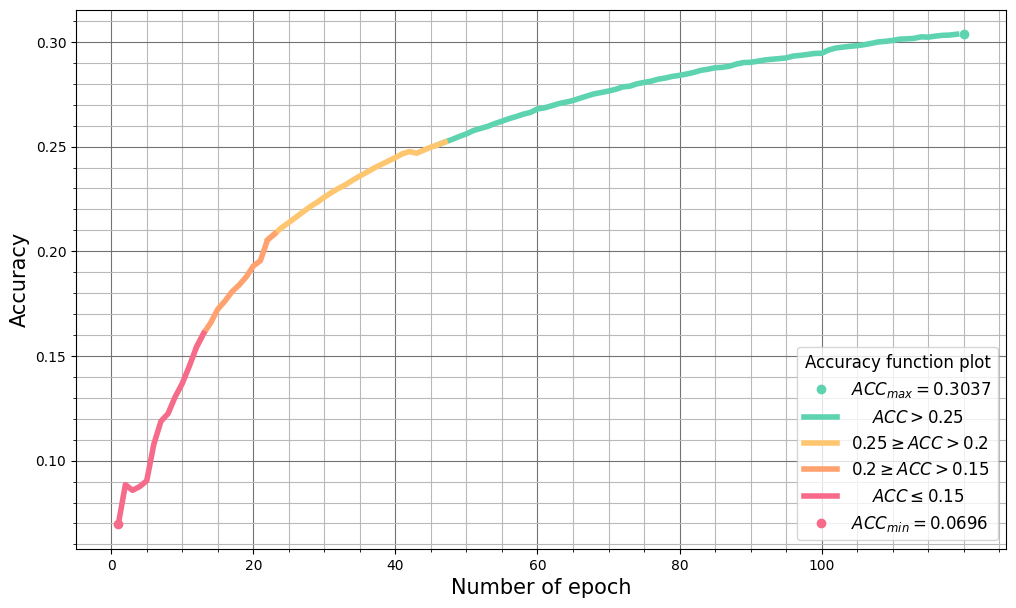

In [37]:
accuracy = [list(filter(lambda x: x< 0.15, history['_count_accuracy'])), list(filter(lambda x: 0.20 >x>= 0.15, history['_count_accuracy'])), list(filter(lambda x: 0.25 > x >= 0.20, history['_count_accuracy'])), list(filter(lambda x: x >= 0.25, history['_count_accuracy']))]
accuracy[0].extend([accuracy[1][0], accuracy[1][1]])
accuracy[1].extend([accuracy[2][0], accuracy[2][1]])
accuracy[2].extend([accuracy[3][0], accuracy[3][1]])
plot_results(accuracy, 'accuracy', [0.25, 0.20, 0.15, 0.15])

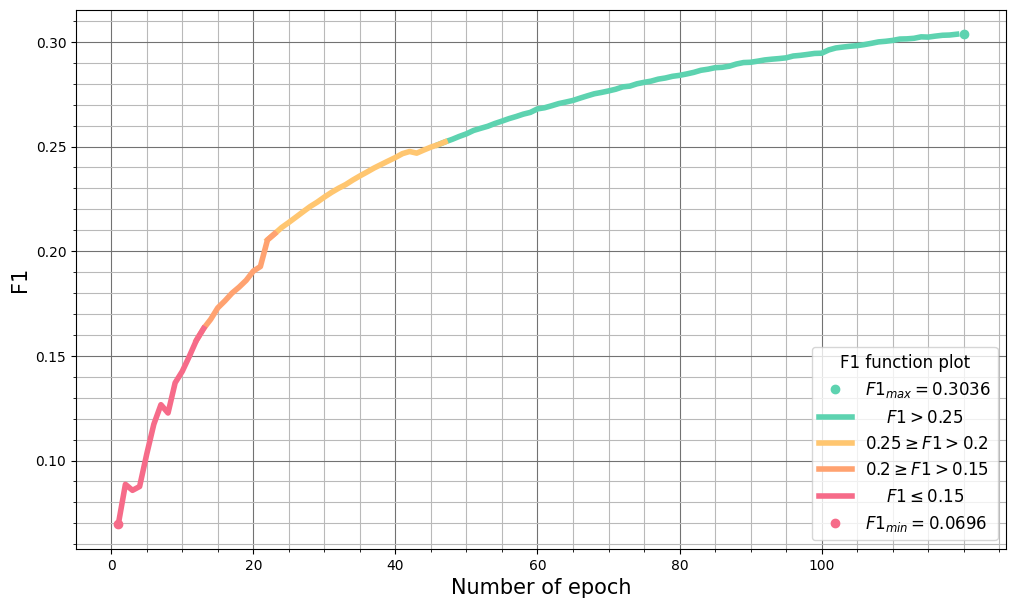

In [38]:
f1 = [list(filter(lambda x: x< 0.15, history['_count_f1'])), list(filter(lambda x: 0.20 >x>= 0.15, history['_count_f1'])), list(filter(lambda x: 0.25 > x >= 0.20, history['_count_f1'])), list(filter(lambda x: x >= 0.25, history['_count_f1']))]
f1[0].extend([f1[1][0], f1[1][1]])
f1[1].extend([f1[2][0], f1[2][1]])
f1[2].extend([f1[3][0], f1[3][1]])
plot_results(f1, 'f1', [0.25, 0.20, 0.15, 0.15])

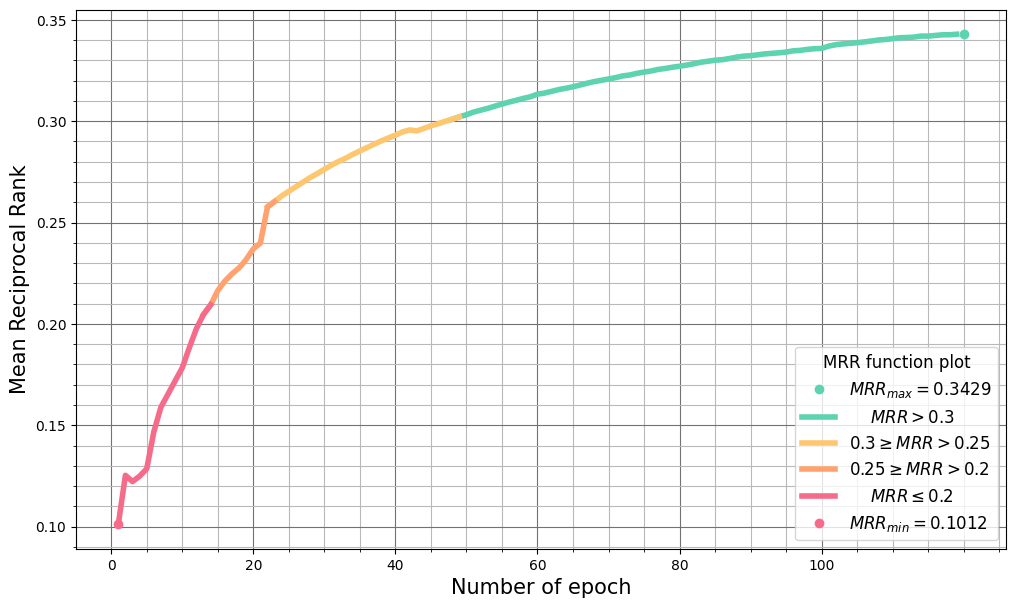

In [41]:
mrr = [list(filter(lambda x: x< 0.2, history['_count_mrr'])), list(filter(lambda x: 0.25 >x>= 0.2, history['_count_mrr'])), list(filter(lambda x: 0.30 > x >= 0.25, history['_count_mrr'])), list(filter(lambda x: x >= 0.30, history['_count_mrr']))]
mrr[0].extend([mrr[1][0], mrr[1][1]])
mrr[1].extend([mrr[2][0], mrr[2][1]])
mrr[2].extend([mrr[3][0], mrr[3][1]])
plot_results(mrr, 'mrr', [0.3, 0.25, 0.2, 0.2])

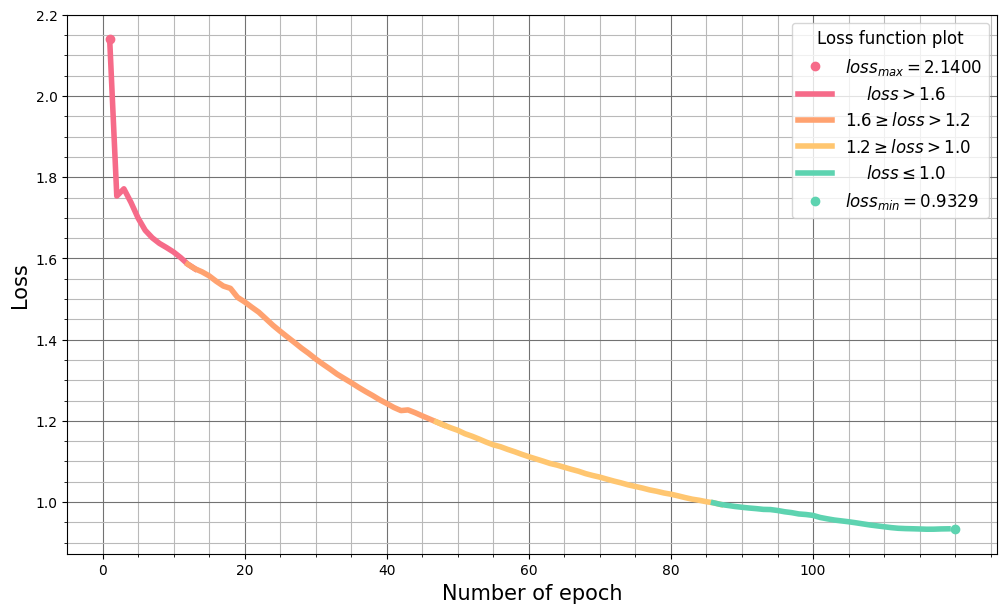

In [43]:
loss = [list(filter(lambda x: x> 1.6, history['loss'])), list(filter(lambda x: 1.6 >=x> 1.2, history['loss'])), list(filter(lambda x: 1.2 >=x> 1.0, history['loss'])), list(filter(lambda x: x <= 1.0, history['loss']))]
loss[0].extend([loss[1][0], loss[1][1]])
loss[1].extend([loss[2][0], loss[2][1]])
loss[2].extend([loss[3][0], loss[3][1]])
printer_loss(loss, text='loss')

## Evaluation (BLEU)

In [5]:
from chatbot.transformer import Transformer
model = Transformer(num_epoch=119)
import pandas as pd
data = pd.read_csv('data/dataset.csv', sep=';')
model.fit_data(data=data)
model.compile_model()
# model.chat()

<class 'tensorflow.python.data.ops.dataset_ops.DatasetV2'>: Dictionary generation Corpus(lang='en', max_length=30, batch_size=32, buffer_size=20000, _start_token=0, _end_token=0, _vocab_size=0, fre=0.0, av_sent_len=0.0). 
	Please be patient. Depending on the size of the dataset and 
	the number of unique words, this can take a while (up to 5 minutes).
Data loaded with hyperparams: Corpus(lang='en', max_length=30, batch_size=32, buffer_size=20000, _start_token=[69175], _end_token=[69176], _vocab_size=69177, fre=87.513, av_sent_len=17.601).
<keras.engine.functional.Functional object at 0x00000216F350AE90> compiled successfully.


{}

In [6]:
from nltk.translate.bleu_score import sentence_bleu
from chatbot.preprocessor import preprocess_sentence
from tqdm import tqdm
import numpy as np
import warnings
warnings.simplefilter('ignore')

d = [{'question':preprocess_sentence(s), 'answers': [preprocess_sentence(i) for i in x['answer'].values.tolist()], 'emotion': preprocess_sentence(list(set(x['emotion'].values.tolist()))[0]), 'category': preprocess_sentence(list(set(x['category'].values.tolist()))[0])} for s,x in data.groupby('question')]
new_df = pd.DataFrame(d)
new_df = new_df.sample(frac=0.3)
new_df.head(10)

,question,answers,emotion,category
10661,i wish i had someone to spend my days with . i...,[try online dating ! its actually really fun ....,disappointed,minorities
3142,i cant believe my daughter drank my last dr pe...,[thats awfulcomma sorry to hear that . i love ...,annoyed,business
14651,my roommates friend comes over and just eats a...,[my roommates friend comes over and just eats ...,disgusted,business
764,every thanksgiving i eat alone .,[really ? thats one of the saddest things ive ...,disappointed,politics
11965,just got back from a grocery store . a girl wa...,"[i stuttered and excused myself ., good luck n...",excited,business
455,after my divorce i have no one .,[you may have more than you know but sometimes...,disappointed,sports
17752,i am so upset my classmate got th lead in the ...,[nocomma because she stole my part . i wanted ...,annoyed,culture
801,everyone has already left the office . its odd...,[i have to wait for something to come in . not...,excited,politics
8568,i was a little shocked when my brother paid fo...,"[how sweet of him ., oh wowcomma any special r...",excited,home living
17210,when i graduated from college i was so happy w...,"[what journey ? do tell ., i am so happy with ...",impressed,culture


In [7]:
predictions: list[str] = model.chat(data=new_df)
bleu_score: list[float] = []

100%|██████████| 5758/5758 [3:30:02<00:00,  2.19s/it]  


In [8]:
references: list[list[str]] = list(new_df['answers'])
ref_split = []
for el in references:
    temp = []
    for sent in el:
        temp.append(sent.split())
    ref_split.append(temp)
for ref, cand in zip(ref_split, predictions):
    bleu_score.append(sentence_bleu(ref, cand[0].split()))
bleu_score = np.array(bleu_score)
print(f'BLEU: {np.mean(bleu_score[(1 > bleu_score) & (bleu_score > 0.1)])}')

BLEU: 0.31151744535942294
